# Lab 6: Convolutional Neural Networks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow import keras 
import sklearn
from sklearn.preprocessing import StandardScaler

In [ ]:
def load_names(file):
    with open(file, 'rb') as fl:
        batch = pickle.load(fl, encoding='latin1')
    
    label_names = batch['label_names']
    return label_names

def load_data(file):
    with open(file, 'rb') as fl:
        batch = pickle.load(fl, encoding='latin1')
        
    features = batch['data']
    labels = batch['labels']
    return features, labels

batch1, label1 = load_data('data_batch_1')
batch2, label2 = load_data('data_batch_2')
batch3, label3 = load_data('data_batch_3')
batch4, label4 = load_data('data_batch_4')
batch5, label5 = load_data('data_batch_5')
X_test, y_test = load_data('test_batch')
label_names = load_names('batches.meta')

#concatenating files 
X_train = np.concatenate([batch1, batch2, batch3, batch4, batch5], 0)
y_train = np.concatenate([label1, label2, label3, label4, label5], 0)
y_test = np.array(y_test)

In [317]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 3072)
(10000, 3072)
(50000,)
(10000,)


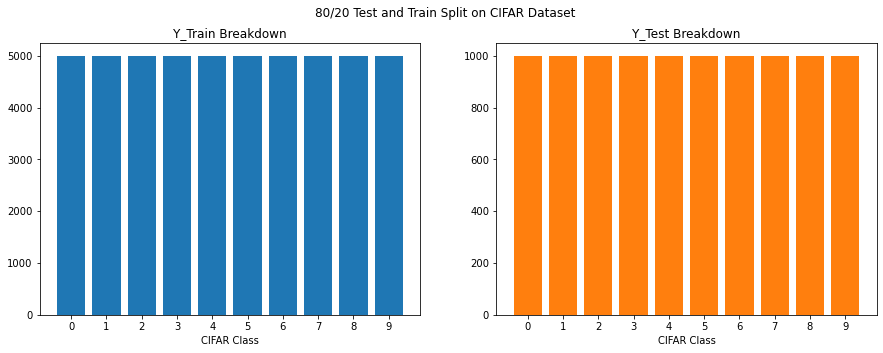

In [318]:
labels = np.arange(10)
train_labels, train_counts =  np.unique(y_train, return_counts=True)
test_labels, test_counts = np.unique(y_test, return_counts=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('80/20 Test and Train Split on CIFAR Dataset')
ax1.bar(train_labels,train_counts, color='tab:blue')
ax2.bar(test_labels,test_counts, color='tab:orange')
ax1.set_title('Y_Train Breakdown')
ax2.set_title('Y_Test Breakdown')
ax1.set_xlabel('CIFAR Class')
ax2.set_xlabel('CIFAR Class')
ax1.set_xticks(labels)
ax2.set_xticks(labels)
plt.show()

## Training-Testing Split Discussion

The CIFAR dataset uploaded from the University of Toronto Department of Computer Science has already splits the training and testing data by 80% and 20% respectively. As you can see from the class distribution aboves, both the training and testing sets are balanced so therefore is no need to split or stratify the data futhermore.  

## Metric Selection

The metrics that we will use to evaluate each algorithm will be the F1 score as well as the Area Under the Receiver Operating Curve. The F1 score is a suitable metric because it is the harmonic mean of precision and recall metrics that measure positive predictive performance. The F1 scores will be calculated per class and averaged so we can evaluate the overall performance. After visualizing the F1 score using confusion matrices, we then help evalaute each model using the receiver operating characteristic curves. The ROC curve plots the true positive rate versus the true negative rate at various thresholds. Each curve represents one class so there will be 10 ROC curves and AUC values per model. Lastly, the multiclass area under the curve will be calculated and will be used to determine the best performing model. 

## Reshaping Input Data 

In [319]:
X_train = X_train.reshape((X_train.shape[0],3,32,32))
X_train = X_train.transpose(0,2,3,1)
X_test = X_test.reshape((X_test.shape[0],3,32,32))
X_test = X_test.transpose(0,2,3,1)

#X_train = np.dot(X_train,[.2989,.587,.1140])
#X_test = np.dot(X_test,[.2989,.587,.1140])

print(np.amin(X_train))
print(np.amax(X_train))
print(X_train.shape)
print(X_test.shape)

0
255
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [320]:
instances, height, width, channels = X_train.shape

print('Instances:',instances)
print('Height:', height)
print('Width:', width)
print('Channels:', channels)

Instances: 50000
Height: 32
Width: 32
Channels: 3


## Normalizing Input Data

In [321]:
X_train = X_train.reshape((X_train.shape[0],height*width*channels))
X_test = X_test.reshape((X_test.shape[0],height*width*channels))

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train = X_train.reshape((X_train.shape[0],height,width, channels))
X_test = X_test.reshape((X_test.shape[0],height,width,channels))

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [322]:
print(np.amin(X_train))
print(np.amax(X_train))

0.0
1.0


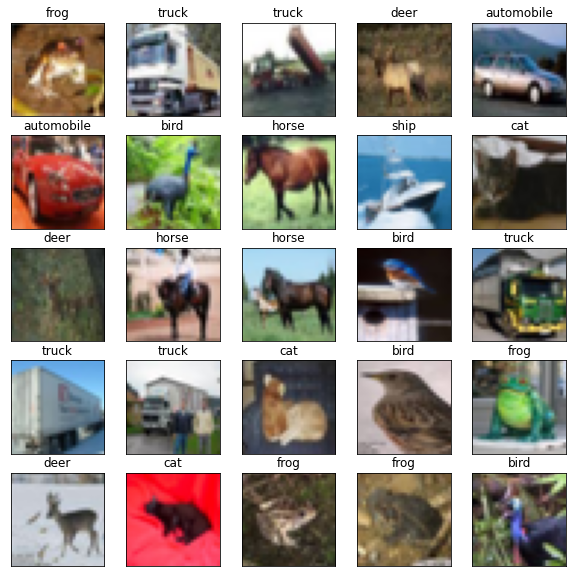

In [323]:
fig = plt.figure(figsize=(10,10))
for i in range(1,26):
    fig.add_subplot(5,5, i)
    plt.imshow(X_train[i-1], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    plt.title('{}'.format(label_names[y_train[i-1]]))

plt.show()

## Data Expansion Using Keras

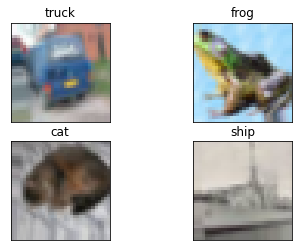

In [324]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
    )

test_datagen = ImageDataGenerator()

#Visualing augmentation
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=None):
    for i in range(0,4):
        plt.subplot(220+1+i)
        plt.imshow(X_batch[i], cmap=plt.cm.gray)
        plt.xticks([])
        plt.yticks([])
        plt.title('{}'.format(label_names[y_batch[i]]))
    plt.show()
    break

## One Hot Encoding of Target Data

In [325]:
num_classes = 10
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
print(y_train.shape)
print(y_test.shape)

(50000, 1)
(10000, 1)


In [326]:
y_train_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_hot = keras.utils.to_categorical(y_test, num_classes)
print(y_train_hot.shape)
print(y_test_hot.shape)

(50000, 10)
(10000, 10)


In [327]:
def loss_plot(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss Plot')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Multi-Layer Perceptron

In [328]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix,classification_report

In [343]:
%%time
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=3072, units=256, activation='relu') )
mlp.add( Dense(units=128, activation='relu') )
mlp.add( Dense(units=64, activation='relu') )
mlp.add( Dense((num_classes), activation='softmax'))

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = mlp.fit(train_datagen.flow(X_train, y_train_hot,batch_size=128), 
        steps_per_epoch = int(len(X_train)/128),
        epochs=10, 
        verbose=1,validation_data=(X_test,y_test_hot))

Epoch 1/10
390/390 [==============================] - 47s 118ms/step - loss: 2.1253 - accuracy: 0.2364 - val_loss: 1.8661 - val_accuracy: 0.3249
Epoch 2/10
390/390 [==============================] - 47s 122ms/step - loss: 1.8754 - accuracy: 0.3225 - val_loss: 1.7312 - val_accuracy: 0.3814
Epoch 3/10
390/390 [==============================] - 50s 127ms/step - loss: 1.7980 - accuracy: 0.3523 - val_loss: 1.6655 - val_accuracy: 0.4044
Epoch 4/10
390/390 [==============================] - 53s 135ms/step - loss: 1.7532 - accuracy: 0.3753 - val_loss: 1.7131 - val_accuracy: 0.3931
Epoch 5/10
390/390 [==============================] - 53s 135ms/step - loss: 1.7142 - accuracy: 0.3842 - val_loss: 1.6214 - val_accuracy: 0.4141
Epoch 6/10
390/390 [==============================] - 53s 135ms/step - loss: 1.6824 - accuracy: 0.3961 - val_loss: 1.5532 - val_accuracy: 0.4425
Epoch 7/10
390/390 [==============================] - 52s 132ms/step - loss: 1.6589 - accuracy: 0.4063 - val_loss: 1.5747 - val_ac

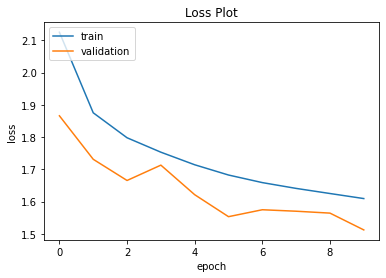

In [344]:
loss_plot(history)

In [346]:
pred_mlp = mlp.predict(X_test, batch_size=128)
pred_mlp_label = np.argmax(pred_mlp, axis=1)

test_acc = accuracy_score(y_test, pred_mlp_label)
ConfusionM = confusion_matrix(list(y_test), pred_mlp_label, labels=[0,1,2,3,4,5,6,7,8,9])
class_report = classification_report(list(y_test), pred_mlp_label, labels=[0,1,2,3,4,5,6,7,8,9])
print(test_acc)
print(ConfusionM)
print(class_report)

79/79 [==============================] - 0s 3ms/step
0.4593
[[401  21 134  40  19   9  49  76 142 109]
 [ 35 462  10  37  16  14  33  37  49 307]
 [ 46  19 365 103  99  28 198  98  19  25]
 [ 12  13  98 349  27  80 253  79  28  61]
 [ 33  10 177  70 327  17 215 105  22  24]
 [  8   6  98 282  32 218 210  93  26  27]
 [  1  13  90  60  63  15 688  39   8  23]
 [ 23   8  68  69  73  34  82 562  15  66]
 [ 95  56  26  36  13  15  26  21 571 141]
 [ 20 107   8  51  11  11  39  57  46 650]]
              precision    recall  f1-score   support

           0       0.59      0.40      0.48      1000
           1       0.65      0.46      0.54      1000
           2       0.34      0.36      0.35      1000
           3       0.32      0.35      0.33      1000
           4       0.48      0.33      0.39      1000
           5       0.49      0.22      0.30      1000
           6       0.38      0.69      0.49      1000
           7       0.48      0.56      0.52      1000
           8       0.6

## Convolutional Neural Networks: 2 Architectures

## Architecture 1: Smaller Filter and Kernel Size

In [329]:
%%time

cnn1 = Sequential()
cnn1.add(Conv2D(filters=16,
                input_shape=X_train.shape[1:],
                kernel_size=(2,2),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn1.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(2,2),
                padding='same',
                activation='relu',))

cnn1.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn1.add(Flatten())
cnn1.add(Dense(256,activation='relu'))
cnn1.add(Dense(num_classes))
cnn1.add(Activation('softmax'))

cnn1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = cnn1.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=10, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/10
390/390 [==============================] - 109s 272ms/step - loss: 1.6638 - accuracy: 0.4018 - val_loss: 1.4441 - val_accuracy: 0.4969
Epoch 2/10
390/390 [==============================] - 102s 261ms/step - loss: 1.3797 - accuracy: 0.5071 - val_loss: 1.2921 - val_accuracy: 0.5414
Epoch 3/10
390/390 [==============================] - 101s 258ms/step - loss: 1.2477 - accuracy: 0.5551 - val_loss: 1.1473 - val_accuracy: 0.5970
Epoch 4/10
390/390 [==============================] - 38s 98ms/step - loss: 1.1602 - accuracy: 0.5886 - val_loss: 1.1456 - val_accuracy: 0.6106
Epoch 5/10
390/390 [==============================] - 38s 96ms/step - loss: 1.0970 - accuracy: 0.6082 - val_loss: 1.1348 - val_accuracy: 0.6114
Epoch 6/10
390/390 [==============================] - 45s 116ms/step - loss: 1.0518 - accuracy: 0.6269 - val_loss: 1.1004 - val_accuracy: 0.6228
Epoch 7/10
390/390 [==============================] - 59s 150ms/step - loss: 1.0079 - accuracy: 0.6455 - val_loss: 1.0610 - val_a

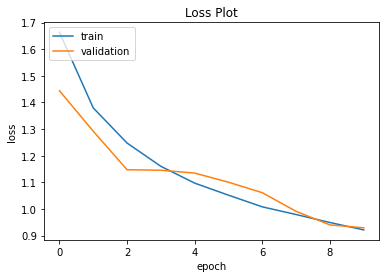

In [330]:
loss_plot(history)

In [336]:
pred1 = cnn1.predict(X_test, batch_size=128)
pred1_label = np.argmax(pred1, axis=1)

test_acc = accuracy_score(y_test, pred1_label)
ConfusionM = confusion_matrix(list(y_test), pred1_label, labels=[0,1,2,3,4,5,6,7,8,9])
class_report = classification_report(list(y_test), pred1_label, labels=[0,1,2,3,4,5,6,7,8,9])
print(test_acc)
print(ConfusionM)
print(class_report)

79/79 [==============================] - 1s 8ms/step
0.6831
[[732  50  65   7  11   3  13  11  38  70]
 [ 10 882   0   2   0   0  10   0  10  86]
 [ 63  17 476  27 109  53 183  40   8  24]
 [ 19  41  52 377  66 139 211  34  15  46]
 [ 15  13  44  22 613  10 181  86  11   5]
 [ 11  15  55 128  66 541  93  58   6  27]
 [  3   7  11  17  20   4 921   4   2  11]
 [ 10  13  36  22  51  34  29 757   0  48]
 [ 87  89  15   4   1   2  13   2 718  69]
 [ 22 129   4   1   1   1  11   9   8 814]]
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1000
           1       0.70      0.88      0.78      1000
           2       0.63      0.48      0.54      1000
           3       0.62      0.38      0.47      1000
           4       0.65      0.61      0.63      1000
           5       0.69      0.54      0.61      1000
           6       0.55      0.92      0.69      1000
           7       0.76      0.76      0.76      1000
           8       0.8

## Architecture 1: Larger Filter and Kernel Sizes

In [332]:
%%time

cnn2 = Sequential()
cnn2.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn2.add(Conv2D(filters=64,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))

cnn2.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn2.add(Flatten())
cnn2.add(Dense(256,activation='relu'))
cnn2.add(Dense(num_classes))
cnn2.add(Activation('softmax'))

cnn2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = cnn2.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=10, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/10
390/390 [==============================] - 82s 208ms/step - loss: 1.6009 - accuracy: 0.4334 - val_loss: 1.2794 - val_accuracy: 0.5589
Epoch 2/10
390/390 [==============================] - 79s 202ms/step - loss: 1.2292 - accuracy: 0.5667 - val_loss: 1.1251 - val_accuracy: 0.6105
Epoch 3/10
390/390 [==============================] - 82s 210ms/step - loss: 1.0940 - accuracy: 0.6138 - val_loss: 1.1001 - val_accuracy: 0.6268
Epoch 4/10
390/390 [==============================] - 76s 195ms/step - loss: 1.0158 - accuracy: 0.6440 - val_loss: 0.9340 - val_accuracy: 0.6778
Epoch 5/10
390/390 [==============================] - 86s 220ms/step - loss: 0.9548 - accuracy: 0.6643 - val_loss: 1.0659 - val_accuracy: 0.6484
Epoch 6/10
390/390 [==============================] - 88s 224ms/step - loss: 0.9104 - accuracy: 0.6830 - val_loss: 0.9741 - val_accuracy: 0.6704
Epoch 7/10
390/390 [==============================] - 88s 226ms/step - loss: 0.8743 - accuracy: 0.6957 - val_loss: 0.8005 - val_ac

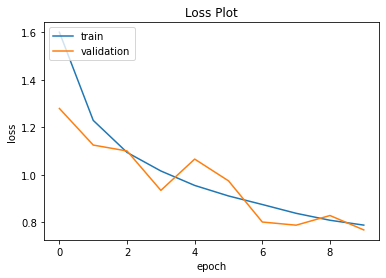

In [333]:
loss_plot(history)

In [335]:
pred2 = cnn2.predict(X_test, batch_size=128)
pred2_label = np.argmax(pred2, axis=1)

test_acc = accuracy_score(y_test, pred2_label)
ConfusionM = confusion_matrix(list(y_test), pred2_label, labels=[0,1,2,3,4,5,6,7,8,9])
class_report = classification_report(list(y_test), pred2_label, labels=[0,1,2,3,4,5,6,7,8,9])
print(test_acc)
print(ConfusionM)
print(class_report)

79/79 [==============================] - 2s 30ms/step
0.7494
[[775  27  23   8  19   2  14   6  58  68]
 [  6 883   1   2   1   1   9   1  13  83]
 [ 66   7 570  34 110  38  92  40  22  21]
 [ 20  17  43 507  93 105 102  57  24  32]
 [ 20   3  34  25 719  11  86  86  10   6]
 [ 13  10  27 146  70 577  48  79  10  20]
 [  7   8  18  26  33   5 890   5   2   6]
 [ 14   7  16  18  53  26  13 831   5  17]
 [ 47  38   3   3   2   1   7   1 850  48]
 [ 12  63   3   6   6   0   3   5  10 892]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1000
           1       0.83      0.88      0.86      1000
           2       0.77      0.57      0.66      1000
           3       0.65      0.51      0.57      1000
           4       0.65      0.72      0.68      1000
           5       0.75      0.58      0.65      1000
           6       0.70      0.89      0.79      1000
           7       0.75      0.83      0.79      1000
           8       0.

## Architecture 2: Smaller Filter and Kernel Sizes

In [337]:
%%time

cnn3 = Sequential()
cnn3.add(Conv2D(filters=16,
                input_shape=X_train.shape[1:],
                kernel_size=(2,2),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn3.add(Conv2D(filters=16,
                input_shape=X_train.shape[1:],
                kernel_size=(2,2),
                padding='same',
                activation='relu',))

cnn3.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))

cnn3.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(2,2),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn3.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(2,2),
                padding='same',
                activation='relu',))

cnn3.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))

cnn3.add(Flatten())
cnn3.add(Dense(256,activation='relu'))
cnn3.add(Dense(num_classes))
cnn3.add(Activation('softmax'))

cnn3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = cnn3.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=10, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/10
390/390 [==============================] - 57s 142ms/step - loss: 1.7027 - accuracy: 0.3844 - val_loss: 1.4368 - val_accuracy: 0.4762
Epoch 2/10
390/390 [==============================] - 55s 141ms/step - loss: 1.4193 - accuracy: 0.4926 - val_loss: 1.2879 - val_accuracy: 0.5429
Epoch 3/10
390/390 [==============================] - 56s 144ms/step - loss: 1.2861 - accuracy: 0.5384 - val_loss: 1.1888 - val_accuracy: 0.5760
Epoch 4/10
390/390 [==============================] - 57s 146ms/step - loss: 1.1817 - accuracy: 0.5778 - val_loss: 1.1424 - val_accuracy: 0.5897
Epoch 5/10
390/390 [==============================] - 59s 151ms/step - loss: 1.1125 - accuracy: 0.6073 - val_loss: 1.0670 - val_accuracy: 0.6219
Epoch 6/10
390/390 [==============================] - 59s 150ms/step - loss: 1.0533 - accuracy: 0.6279 - val_loss: 1.0803 - val_accuracy: 0.6251
Epoch 7/10
390/390 [==============================] - 59s 152ms/step - loss: 1.0101 - accuracy: 0.6440 - val_loss: 0.9716 - val_ac

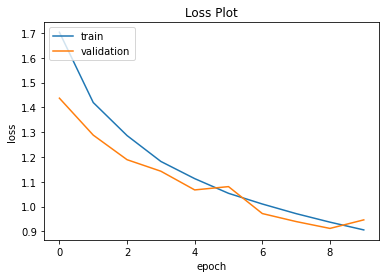

In [338]:
loss_plot(history)

In [339]:
pred3 = cnn3.predict(X_test, batch_size=128)
pred3_label = np.argmax(pred3, axis=1)

test_acc = accuracy_score(y_test, pred3_label)
ConfusionM = confusion_matrix(list(y_test), pred3_label, labels=[0,1,2,3,4,5,6,7,8,9])
class_report = classification_report(list(y_test), pred3_label, labels=[0,1,2,3,4,5,6,7,8,9])
print(test_acc)
print(ConfusionM)
print(class_report)

79/79 [==============================] - 1s 7ms/step
0.6757
[[766  62  13   6   2   2   4  10  58  77]
 [  8 915   0   1   0   1   0   0   9  66]
 [105  26 510  54  55  30 106  45  16  53]
 [ 40  66  51 467  43  74 110  53  39  57]
 [ 36  34  71  48 460  19 163 137  19  13]
 [ 26  27  40 209  28 456  62  82  22  48]
 [ 15  45  22  34   9   5 823   5  13  29]
 [ 24  23  26  20  26  19  20 778   5  59]
 [ 78  80   4   3   1   1   3   2 771  57]
 [ 21 148   1   2   0   0   1   5  11 811]]
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      1000
           1       0.64      0.92      0.75      1000
           2       0.69      0.51      0.59      1000
           3       0.55      0.47      0.51      1000
           4       0.74      0.46      0.57      1000
           5       0.75      0.46      0.57      1000
           6       0.64      0.82      0.72      1000
           7       0.70      0.78      0.74      1000
           8       0.8

## Architecture 2: Larger Filter and Kernel Sizes

In [340]:
%%time

cnn4 = Sequential()
cnn4.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn4.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))

cnn4.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))

cnn4.add(Conv2D(filters=64,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn4.add(Conv2D(filters=64,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))

cnn4.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))

cnn4.add(Flatten())
cnn4.add(Dense(256,activation='relu'))
cnn4.add(Dense(num_classes))
cnn4.add(Activation('softmax'))

cnn4.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = cnn4.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=10, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/10
390/390 [==============================] - 84s 210ms/step - loss: 1.7616 - accuracy: 0.3654 - val_loss: 1.3155 - val_accuracy: 0.5258
Epoch 2/10
390/390 [==============================] - 85s 218ms/step - loss: 1.3335 - accuracy: 0.5233 - val_loss: 1.1854 - val_accuracy: 0.5821
Epoch 3/10
390/390 [==============================] - 87s 223ms/step - loss: 1.1336 - accuracy: 0.6000 - val_loss: 1.1061 - val_accuracy: 0.6238
Epoch 4/10
390/390 [==============================] - 85s 218ms/step - loss: 1.0038 - accuracy: 0.6482 - val_loss: 0.9755 - val_accuracy: 0.6758
Epoch 5/10
390/390 [==============================] - 87s 221ms/step - loss: 0.9093 - accuracy: 0.6802 - val_loss: 0.7743 - val_accuracy: 0.7357
Epoch 6/10
390/390 [==============================] - 88s 226ms/step - loss: 0.8424 - accuracy: 0.7040 - val_loss: 0.7812 - val_accuracy: 0.7343
Epoch 7/10
390/390 [==============================] - 87s 222ms/step - loss: 0.7842 - accuracy: 0.7264 - val_loss: 0.7648 - val_ac

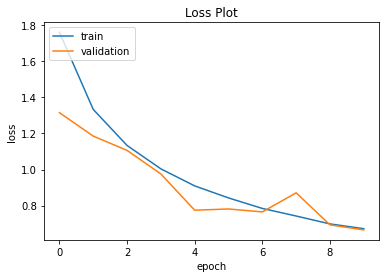

In [341]:
loss_plot(history)

In [342]:
pred4 = cnn4.predict(X_test, batch_size=128)
pred4_label = np.argmax(pred4, axis=1)

test_acc = accuracy_score(y_test, pred1_label)
ConfusionM = confusion_matrix(list(y_test), pred4_label, labels=[0,1,2,3,4,5,6,7,8,9])
class_report = classification_report(list(y_test), pred4_label, labels=[0,1,2,3,4,5,6,7,8,9])
print(test_acc)
print(ConfusionM)
print(class_report)

79/79 [==============================] - 2s 29ms/step
0.6831
[[871  15  21  11  13   2   4  12  18  33]
 [ 11 919   2   3   2   1   2   1   6  53]
 [ 81   5 670  51  55  53  48  20   4  13]
 [ 45  14  51 544  57 173  57  33   7  19]
 [ 23   5  66  37 738  25  58  40   4   4]
 [ 25   7  40 121  40 705  20  31   3   8]
 [ 14   7  37  54  14  23 839   5   3   4]
 [ 27   7  33  23  45  32   6 810   0  17]
 [ 99  38  13   9   6   3   4   3 791  34]
 [ 39  82   2   5   8   1   0   5   6 852]]
              precision    recall  f1-score   support

           0       0.71      0.87      0.78      1000
           1       0.84      0.92      0.88      1000
           2       0.72      0.67      0.69      1000
           3       0.63      0.54      0.59      1000
           4       0.75      0.74      0.75      1000
           5       0.69      0.70      0.70      1000
           6       0.81      0.84      0.82      1000
           7       0.84      0.81      0.83      1000
           8       0.

## Model Comparisons Using Confusion Matrices of F1_Score

In [308]:
def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.f1_score(y_test,yhat_cnn, average='macro')
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('Model 1: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.f1_score(y_test,yhat_mlp, average='macro')
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('Model 2: '+str(acc_mlp))

313/313 [==============================] - 1s 2ms/step


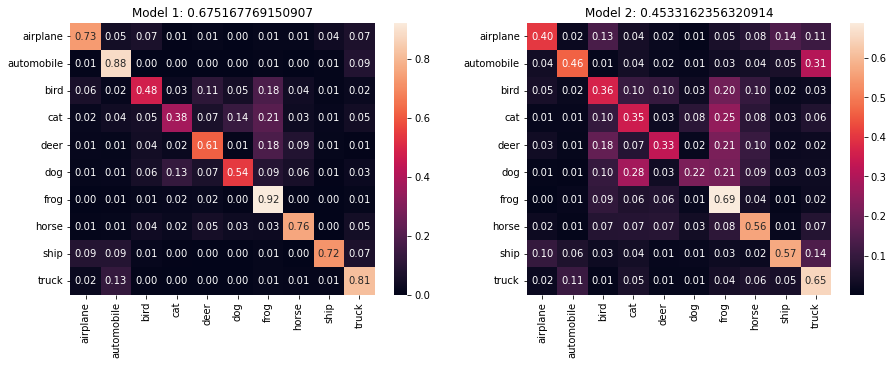

In [347]:
compare_mlp_cnn(cnn1,mlp,X_test,y_test,label_names)

313/313 [==============================] - 3s 9ms/step


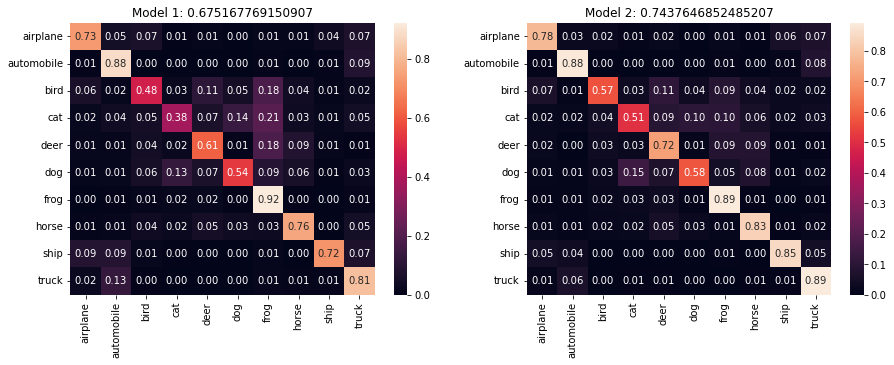

In [348]:
compare_mlp_cnn(cnn1,cnn2,X_test,y_test,label_names)

313/313 [==============================] - 5s 16ms/step


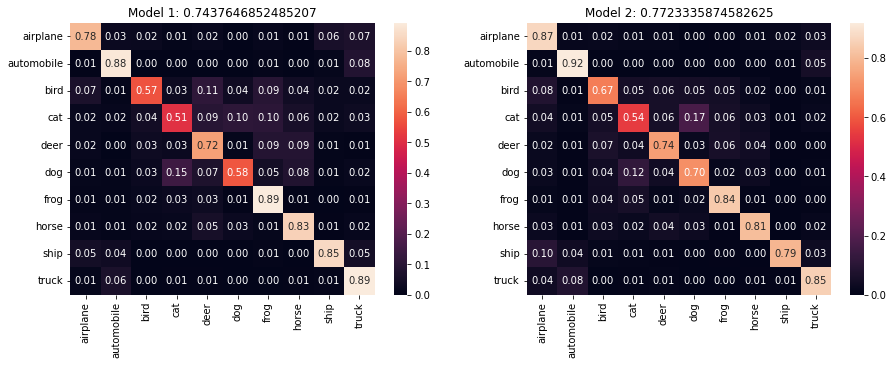

In [349]:
compare_mlp_cnn(cnn2,cnn4,X_test,y_test,label_names)

313/313 [==============================] - 1s 3ms/step


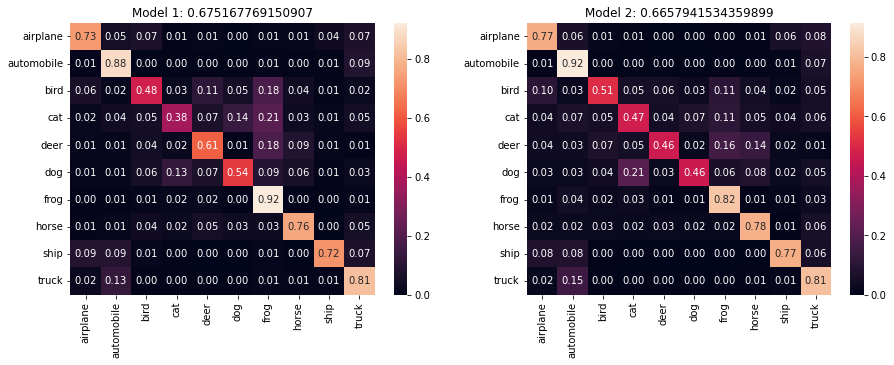

In [350]:
compare_mlp_cnn(cnn1,cnn3,X_test,y_test,label_names)

## Discussion

It appears from the F1 Confusion Matrices of each model per architecture that has the larger filter and kernel sizes ultimately had the better performance. The average F1 score of all of the classes for the larger filter and kernel sizes were at 74% for the single convolution block ann 77% for the two convolution block architecture. In order to further visualize the performance, we will now explore the receiver operating curves of each model and comparing it to the multilayer perceptron.

# Model Comparisons Using ROC Curves

In [256]:
ypred4 = cnn4.predict(X_train)
ypred4 = ypred4.argmax(axis=-1)
ypred4

1563/1563 [==============================] - 37s 24ms/step


array([6, 9, 9, ..., 9, 1, 1], dtype=int64)

In [257]:
ypred3 = cnn3.predict(X_train)
ypred3 = ypred3.argmax(axis=-1)
ypred3

1563/1563 [==============================] - 14s 9ms/step


array([6, 9, 9, ..., 9, 1, 1], dtype=int64)

In [258]:
ypred2 = cnn2.predict(X_train)
ypred2 = ypred2.argmax(axis=-1)
ypred2

1563/1563 [==============================] - 36s 23ms/step


array([6, 9, 9, ..., 9, 1, 1], dtype=int64)

In [259]:
ypred1 = cnn1.predict(X_train)
ypred1 = ypred1.argmax(axis=-1)
ypred1

1563/1563 [==============================] - 14s 9ms/step


array([6, 9, 9, ..., 9, 1, 9], dtype=int64)

In [227]:
ypred_mlp = mlp.predict(X_train)
ypred_mlp = ypred_mlp.argmax(axis=-1)
ypred_mlp

1563/1563 [==============================] - 8s 5ms/step


array([6, 1, 9, ..., 9, 1, 7], dtype=int64)

In [241]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(label_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.7038555555555556


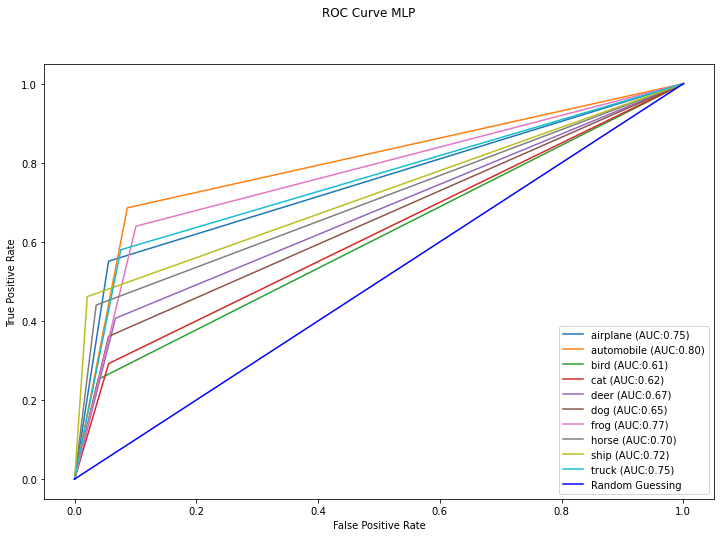

In [271]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(y_train, ypred_mlp))
fig.suptitle('ROC Curve MLP')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.791611111111111


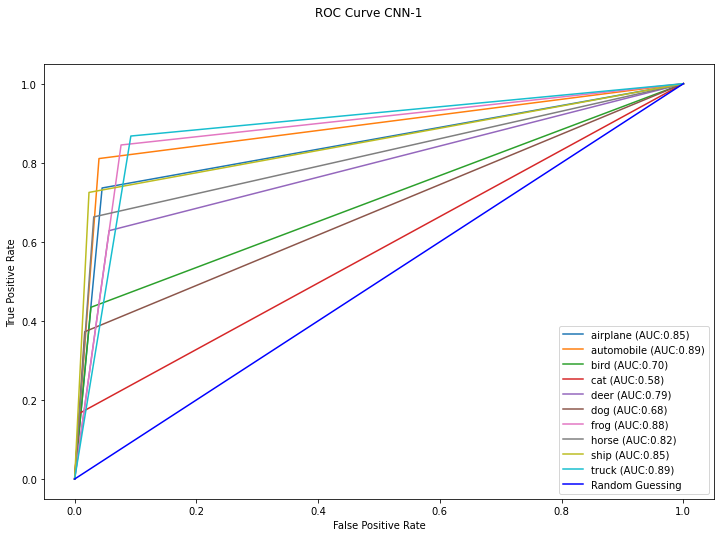

In [270]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred1))
fig.suptitle('ROC Curve CNN-1')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.8503555555555555


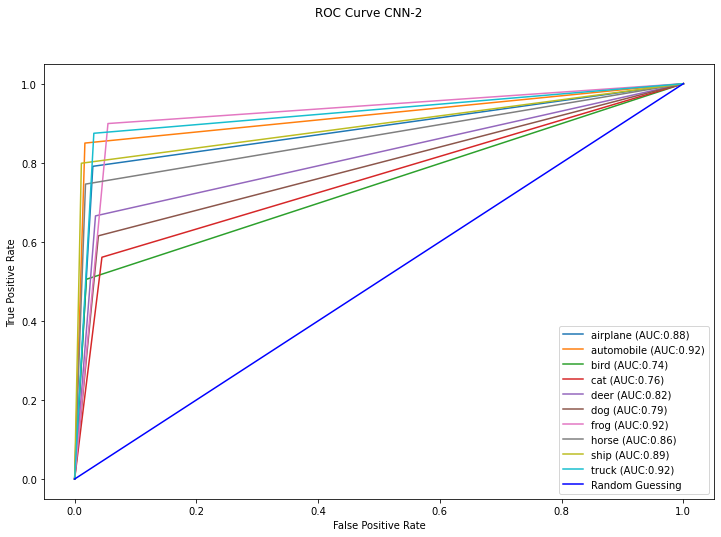

In [269]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred2))
fig.suptitle('ROC Curve CNN-2')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.8191333333333333


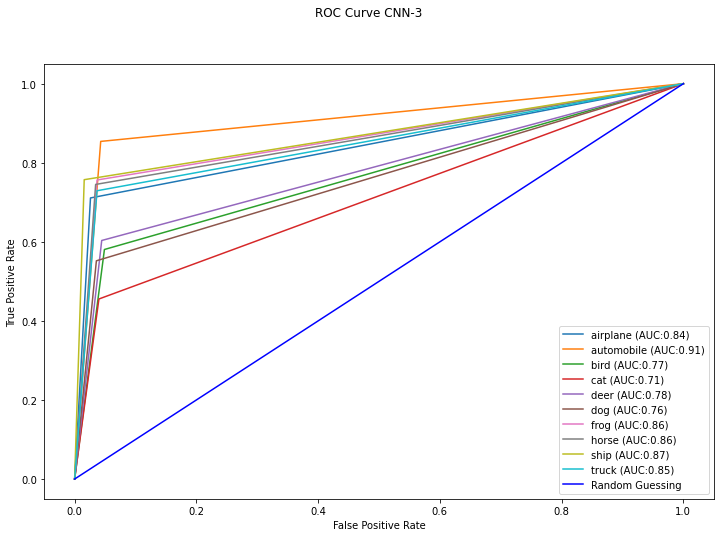

In [268]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred3))
fig.suptitle('ROC Curve CNN-3')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.8477


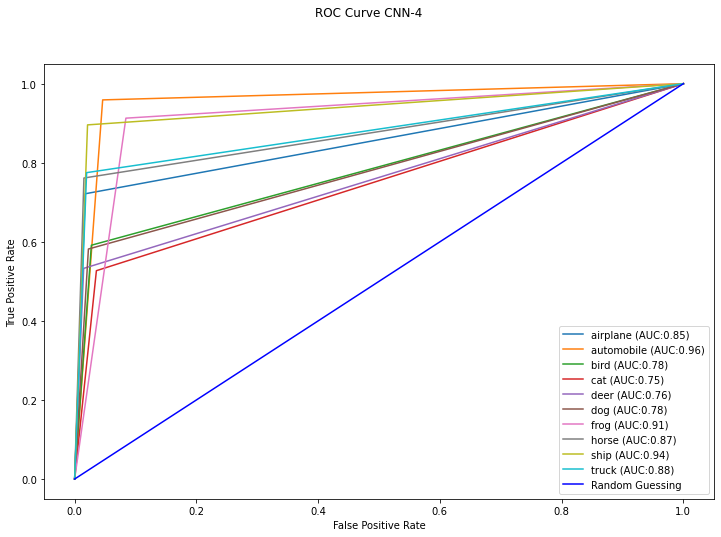

In [267]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred4))
fig.suptitle('ROC Curve CNN-4')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

## Discussion 

Consistent with the Confusion Matrices, The Receiver Operating Characteristic Curves also showed larger AUC values for the models with larger filter and kernel sizes. Moreover, it is clearer to see which classes were the most difficult to classify which were birds, cats, dogs, and deer. The reason for this misclassification would most likely be due to the similar body and facial structures of these classes. On the other hand, it is conceivable to see that classes such as automobiles, ships, trucks, airplanes are easier to classify due to their unique shapes. Clearly, the multilayer perceptron fails to out perform any of the convolutional neural networks most likely due to its propensity towards overfitting.  

Cited from: 
https://stackoverflow.com/questions/66635552/keras-assessing-the-roc-auc-of-multiclass-cnn

## Exceptional Work

Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 

In [ ]:
#Ref: https://www.kaggle.com/code/adi160/cifar-10-keras-transfer-learning

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes = 10

y_train_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_hot = keras.utils.to_categorical(y_test, num_classes)

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import ResNet50
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=10)

In [ ]:
model_1= Sequential()
model_1.add(base_model_1) 
model_1.add(Flatten()) 

In [ ]:
model_1.summary()

In [ ]:
#Add the Dense layers along with activation and batch normalization
#model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_1.add(Dense(128,activation=('relu'),input_dim=512))
#model_1.add(Dropout(.2))
model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [ ]:
model_1.summary()

In [ ]:
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

'Lastly import the final layers that will be added on top of the base model'
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout

'Import to_categorical from the keras utils package to one hot encode the labels'
from tensorflow.keras.utils import to_categorical

batch_size= 32
epochs=3
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#rgb_batch = np.repeat(X_train[..., np.newaxis], 3, -1)
X_train_rgb=np.squeeze(rgb_batch)

rgb_batch_test = np.repeat(X_test[..., np.newaxis], 3, -1)
X_test_rgb=np.squeeze(rgb_batch_test)

print(X_train_rgb.shape)
print(X_test_rgb.shape)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
    )

In [ ]:
model_1.fit_generator(datagen.flow(X_train, y_train_hot,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=X_train.shape[0]//batch_size,
                      validation_data=datagen.flow(X_test,y_test_hot,batch_size=batch_size),validation_steps=250,
                      verbose=1)